In [1]:
import os
import random

# Allow image embedding in notebook
%pip install matplotlib inline

# Install the required packages
%pip install matplotlib scikit-image numpy tensorflow

import matplotlib
import matplotlib.pyplot as plt
import skimage.data
import skimage.transform
import numpy as np
import tensorflow as tf


  Using cached inline-0.0.1.tar.gz (2.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.0 MB 7.5 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.0 MB 7.0 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/8.0 MB 7.1 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 7.0 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.0 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 6.7 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.2 MB 5.6 MB/s eta 0:00:01
 

In [10]:
import os
import skimage.io

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

# Load training and testing datasets.
# Correct the path to the datasets/BelgiumTS folder
ROOT_PATH = "datasets/BelgiumTS"
train_data_dir = os.path.normpath(os.path.join(ROOT_PATH, "Training"))
test_data_dir = os.path.normpath(os.path.join(ROOT_PATH, "Testing"))

images, labels = load_data(train_data_dir)

In [11]:
print("Unique labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique labels: 62
Total Images: 4575


In [6]:
print("Train data directory:", train_data_dir)
print("Test data directory:", test_data_dir)


Train data directory: datasets/BelgiumTS\Training
Test data directory: datasets/BelgiumTS\Testing


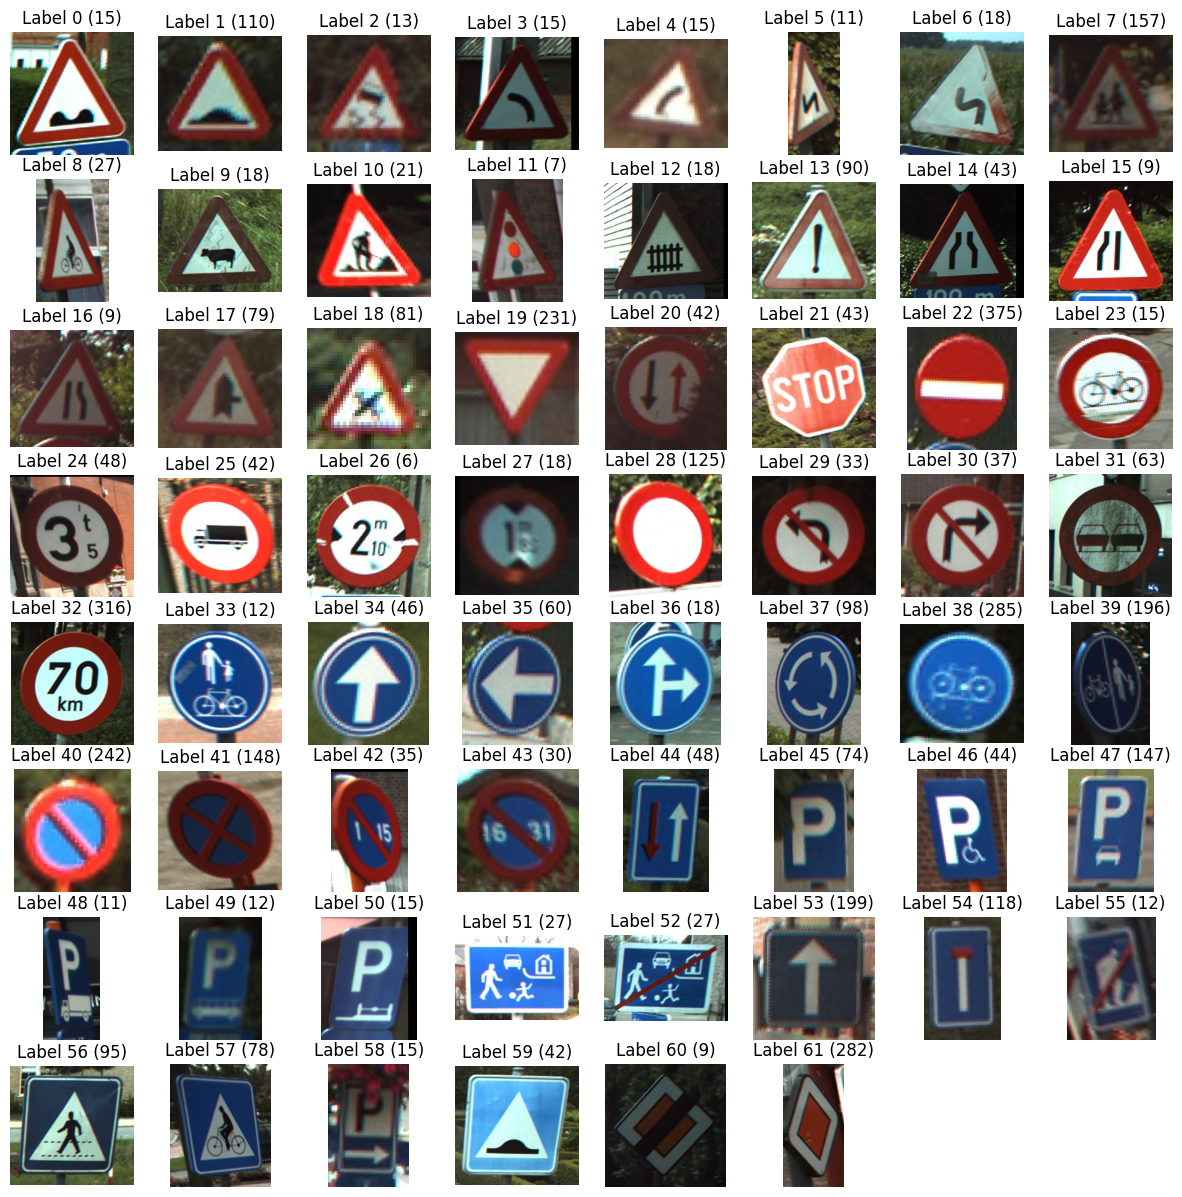

In [12]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

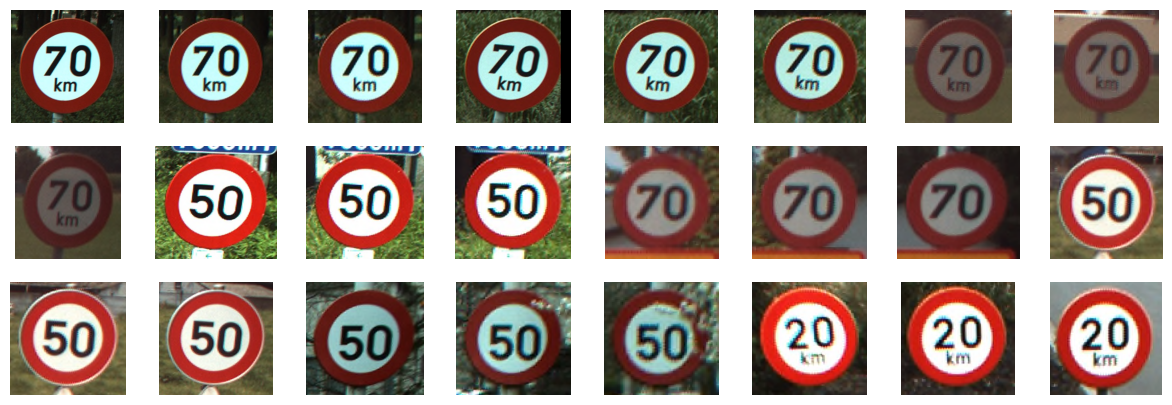

In [13]:
def display_label_images(images, label):
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)


In [14]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


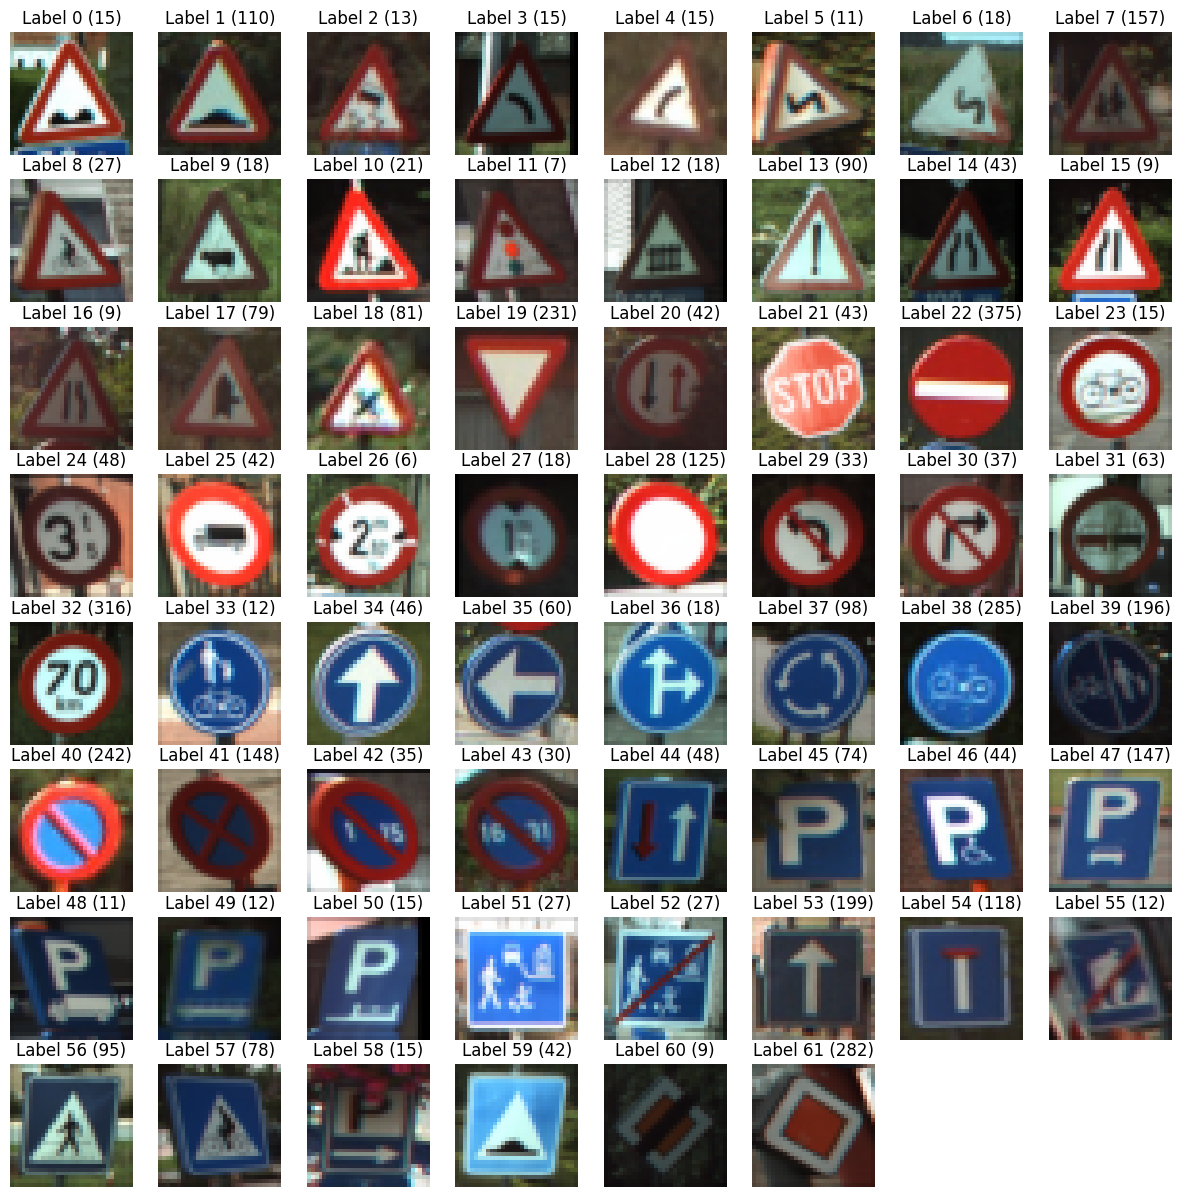

In [15]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [16]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0408831123942043, max: 0.9998171781334138
shape: (32, 32, 3), min: 0.03833391811044041, max: 0.9999986658947251
shape: (32, 32, 3), min: 0.04162877876121437, max: 0.9999971795462242
shape: (32, 32, 3), min: 0.06604801236030763, max: 0.9235668331529523
shape: (32, 32, 3), min: 0.06414078391391745, max: 0.9062750385650252


In [17]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [23]:
# Disable eager execution to use TensorFlow 1.x style
tf.compat.v1.disable_eager_execution()

# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.compat.v1.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.keras.layers.Flatten()(images_ph)

    # Fully connected layer.
    # Generates logits of size [None, 62]
    logits = tf.keras.layers.Dense(62, activation=tf.nn.relu)(images_flat)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function.
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before
    init = tf.compat.v1.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)


images_flat:  Tensor("flatten_2_1/Reshape:0", shape=(None, 3072), dtype=float32)
logits:  Tensor("dense_1/Relu:0", shape=(None, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(None,), dtype=int64)


In [25]:
# Create a session to run the graph we created.
session = tf.compat.v1.Session(graph=graph)

# First step is always to initialize all variables.
# We don't care about the return value, it's None.
_ = session.run([init])

In [26]:
for i in range(201):
    _, loss_value = session.run([train, loss],
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.2585144
Loss:  3.2671938
Loss:  2.8916583
Loss:  2.7032351
Loss:  2.5884757
Loss:  2.5091004
Loss:  2.4505239
Loss:  2.4051847
Loss:  2.3685527
Loss:  2.3379884
Loss:  2.3119464
Loss:  2.2894576
Loss:  2.2697942
Loss:  2.2524252
Loss:  2.236946
Loss:  2.2230463
Loss:  2.2104893
Loss:  2.1990702
Loss:  2.1885996
Loss:  2.1790156
Loss:  2.1702042


In [27]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[56, 38, 22, 52, 20, 1, 54, 41, 57, 39]
[56 38 61 39 28  1 54 22 57 39]


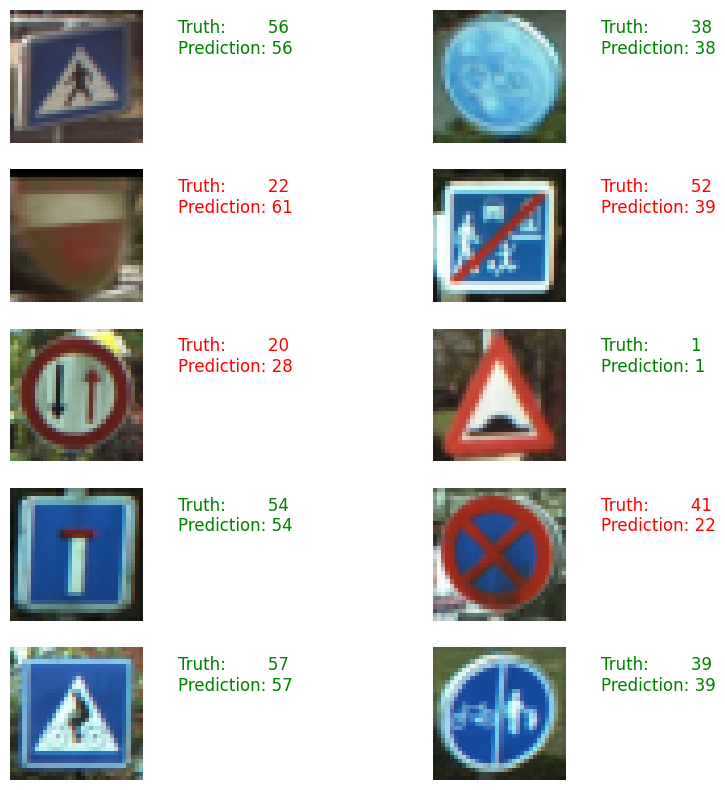

In [28]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [29]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)


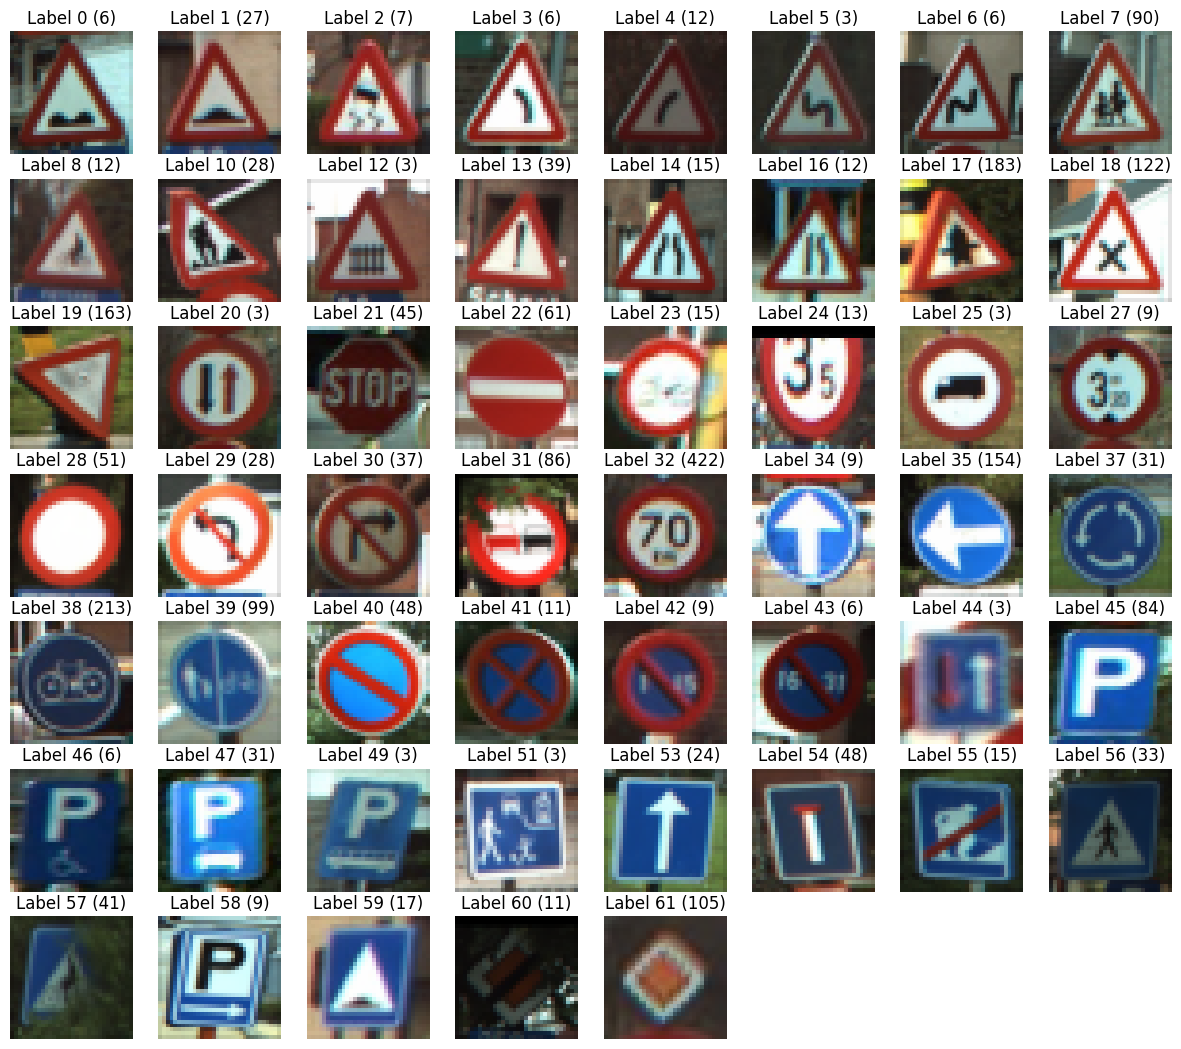

In [30]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)


In [31]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.425


In [32]:
# Close th session. This will destroy the trained model.
session.close()